# TAA Project 1

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from PIL import Image

### Process the data files

In [2]:
meta_path = 'dataset/Meta'
train_path = 'dataset/Train'
test_path = 'dataset/Test'

NUM_CATEGORIES = len(os.listdir(train_path))
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

### Distribution of images per signal on the Train set

Number of classes: 43


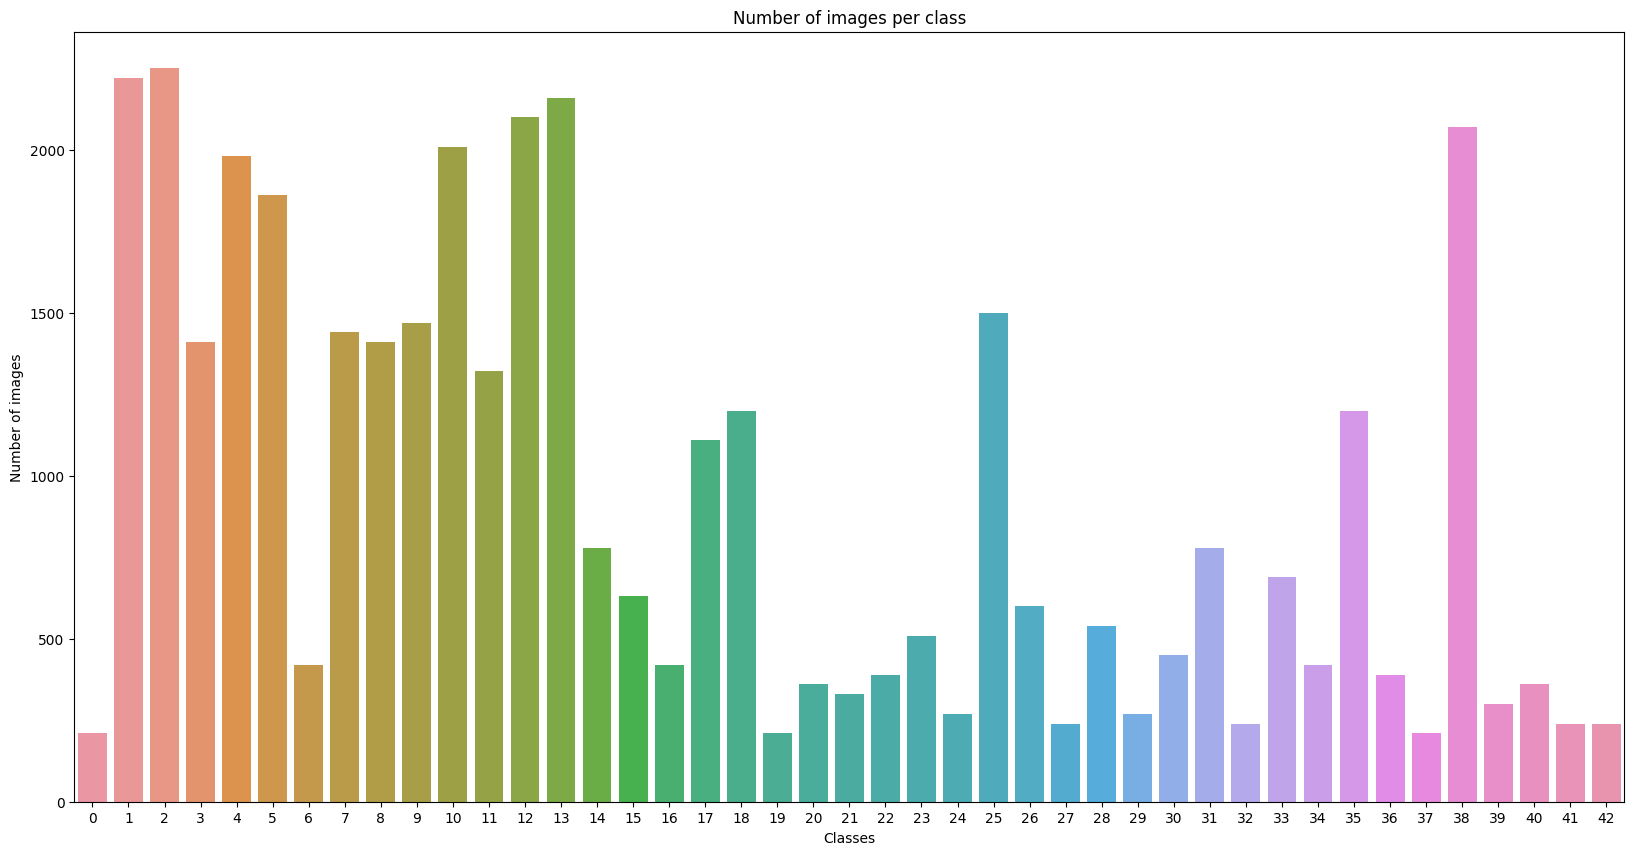

In [3]:
# Get the names of the classes
train = pd.read_csv('dataset/Train.csv')
meta = pd.read_csv('dataset/Meta.csv')
classes = meta['ClassId']
classes = np.array(classes)
classes = np.sort(classes)

print('Number of classes: {}'.format(len(classes)))

# Get the number of images per class
num_images = []
for c in classes:
    num_images.append(len(train[train['ClassId'] == c]))

# Plot the histogram
plt.figure(figsize=(20, 10))
sns.barplot(x=classes, y=num_images)
plt.title('Number of images per class')
plt.xlabel('Classes')
plt.ylabel('Number of images')
plt.savefig('train_distribution.png')
plt.show()


### Subset of images from the Train set

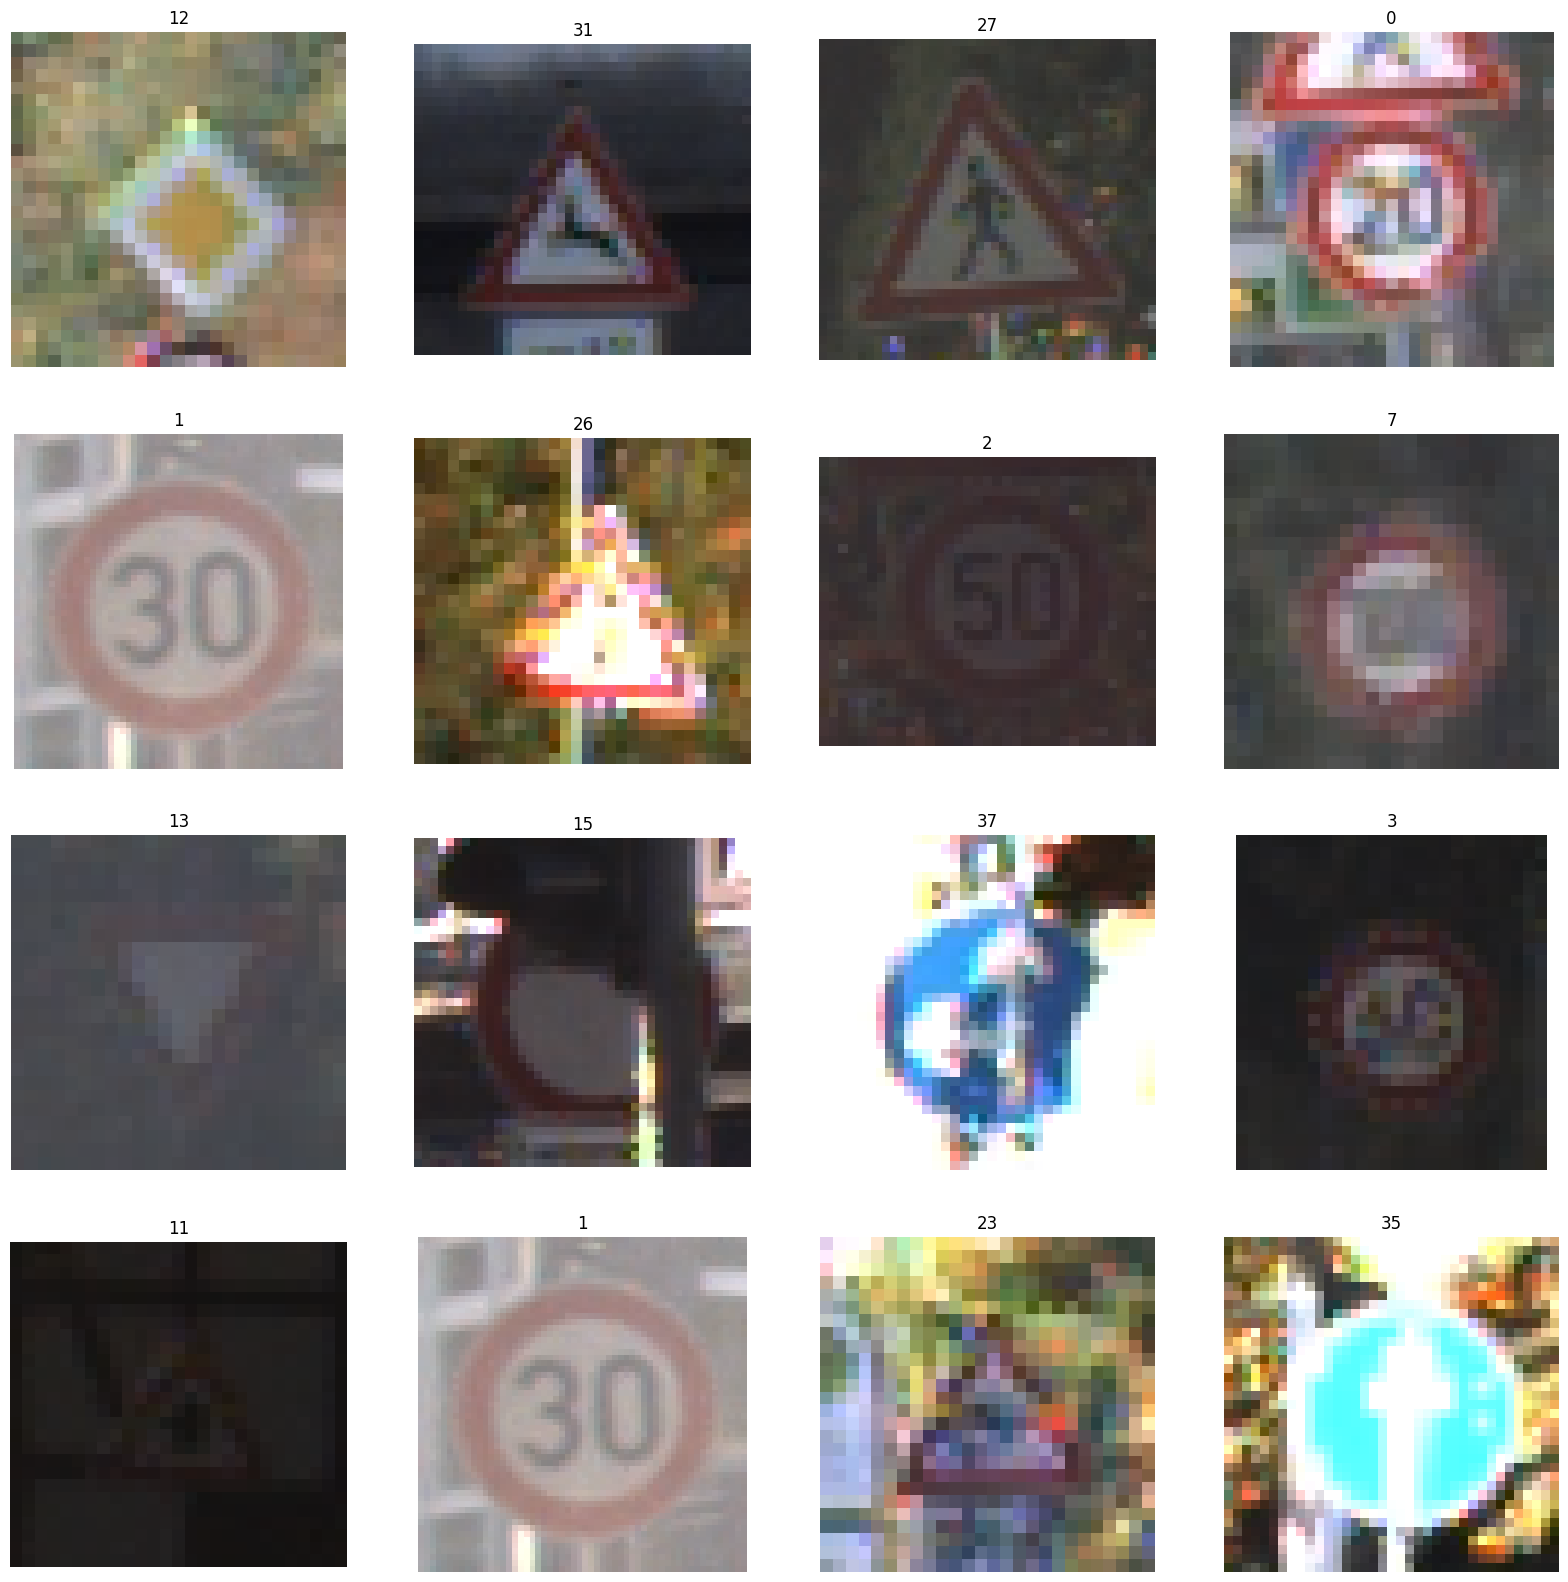

In [4]:
# get a 4x4 grid of 16 random images from the training set
TRAIN_PATH = 'dataset/Train/'
grid_size = 4
con = np.random.choice(classes, size=grid_size*grid_size)
fig, ax = plt.subplots(grid_size, grid_size, figsize=(20, 20))
for i, row in enumerate(ax):
	for j, col in enumerate(row):
		image = Image.open(TRAIN_PATH + str(con[i*grid_size + j]) + '/' + os.listdir(TRAIN_PATH + str(con[i*grid_size + j]))[0])
		col.imshow(image)
		col.axis('off')
		col.set_title(con[i*grid_size + j])
plt.savefig('train_sample.png')
plt.show()


### Subset of images from the Test set

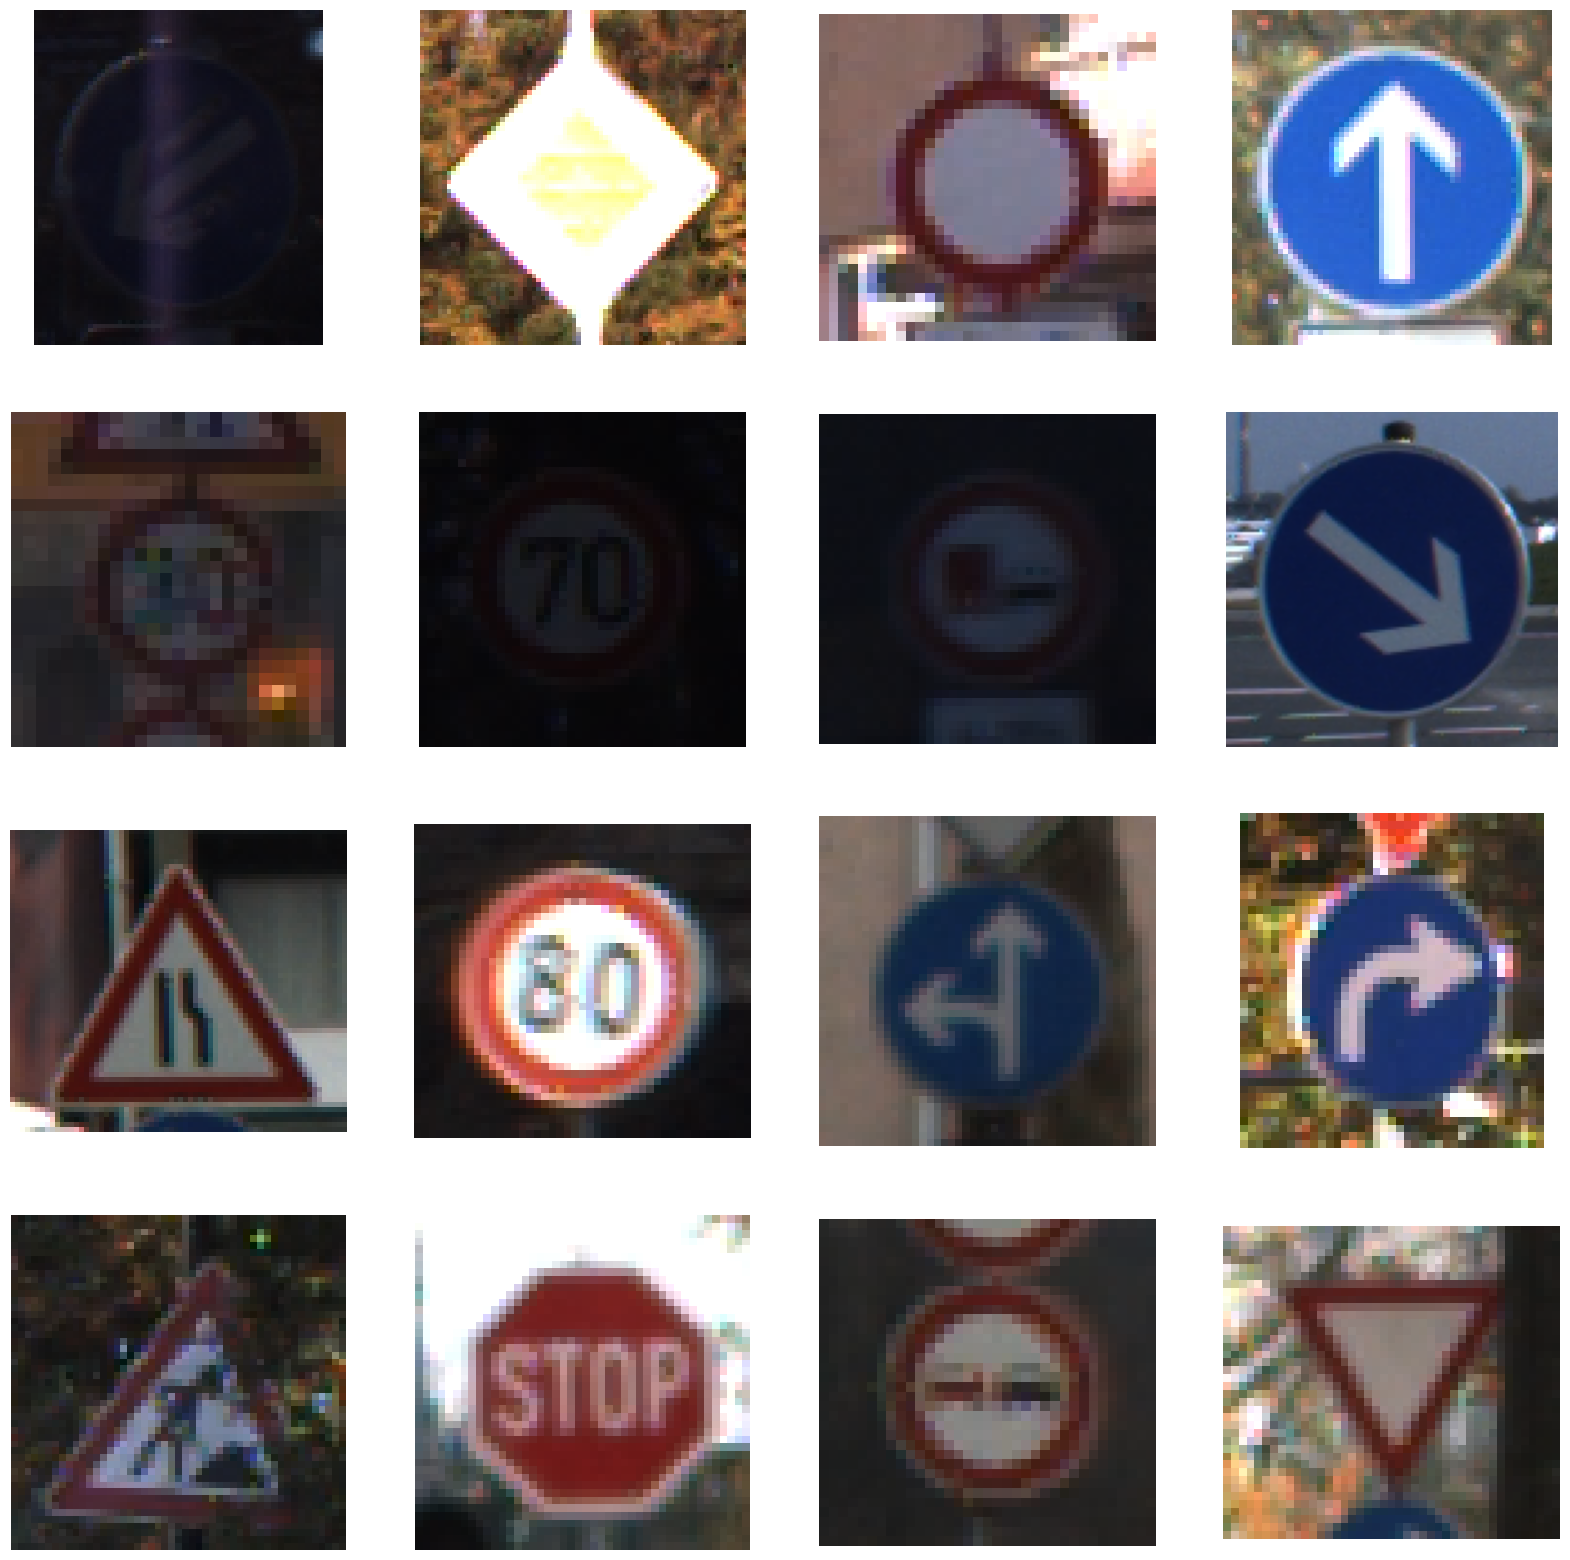

In [5]:
# get a 4x4 grid of 16 random images from the testing set
TEST_PATH = 'dataset/Test/'
grid_size = 4
fig, ax = plt.subplots(grid_size, grid_size, figsize=(20, 20))
for i, row in enumerate(ax):
	for j, col in enumerate(row):
		image = Image.open(TEST_PATH + np.random.choice(os.listdir(TEST_PATH)))
		col.imshow(image)
		col.axis('off')
plt.savefig('test_sample.png')
plt.show()


### Collecting the Training Data

In [6]:
image_data = []
image_labels = []

for i in range(NUM_CATEGORIES):
    path = train_path + '/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = Image.open(path + '/' + img)
            # rgb
            #image_fromarray = Image.fromarray(image, 'RGB')
            # gray_scale
            image_fromarray = image.convert('L')
            
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)

# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(39209, 30, 30) (39209,)


### Shuffling the training data

In [7]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

### Splitting the data into train and validation setSplitting the data into train and validation set

In [8]:
from sklearn.model_selection import train_test_split


X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train/255 
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (27446, 30, 30)
X_valid.shape (11763, 30, 30)
y_train.shape (27446,)
y_valid.shape (11763,)


## Create the model

In [9]:
import tensorflow as tf
import h5py
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.models import load_model
from sklearn.metrics import accuracy_score
np.random.seed(42)

In [10]:
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(27446, 43)
(11763, 43)


In [ ]:
with h5py.File('traffic_classifier_kaggle_fake_gray_scale.h5', 'r') as f:
    model = load_model(f)

In [12]:
model = keras.models.Sequential([ 
    # rgb   
    #keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,channels), padding='same'),
    # gray scale
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,1), padding='same'),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),
    
    keras.layers.Dense(43, activation='softmax')
])

In [13]:
lr = 0.001
epochs = 30

opt = Adam(lr=lr, decay=lr / (epochs * 0.5))
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

c:\Users\Gui\OneDrive\Universidade\3o Ano - UA\2o Semestre\Tópicos de Aprendizagem Automática\Projetos\Projeto 1\taa-projeto-1\venv\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


### Augmenting the data and training the model

In [14]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")
# gray scale
X_train = np.expand_dims(X_train, axis=-1)
history = model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/30
858/858 [==============================] - 94s 108ms/step - loss: 1.0965 - accuracy: 0.7198 - val_loss: 0.1675 - val_accuracy: 0.9498
Epoch 2/30
858/858 [==============================] - 85s 99ms/step - loss: 0.1530 - accuracy: 0.9534 - val_loss: 0.0952 - val_accuracy: 0.9746
Epoch 3/30
858/858 [==============================] - 86s 100ms/step - loss: 0.0949 - accuracy: 0.9714 - val_loss: 0.0395 - val_accuracy: 0.9884
Epoch 4/30
858/858 [==============================] - 86s 100ms/step - loss: 0.0623 - accuracy: 0.9813 - val_loss: 0.0335 - val_accuracy: 0.9891
Epoch 5/30
858/858 [==============================] - 85s 99ms/step - loss: 0.0603 - accuracy: 0.9809 - val_loss: 0.0119 - val_accuracy: 0.9962
Epoch 6/30
858/858 [==============================] - 87s 102ms/step - loss: 0.0487 - accuracy: 0.9857 - val_loss: 0.0146 - val_accuracy: 0.9959
Epoch 7/30
858/858 [==============================] - 89s 104ms/step - loss: 0.0444 - accuracy: 0.9863 - val_loss: 0.0188 - val_accu

### Evaluating the model

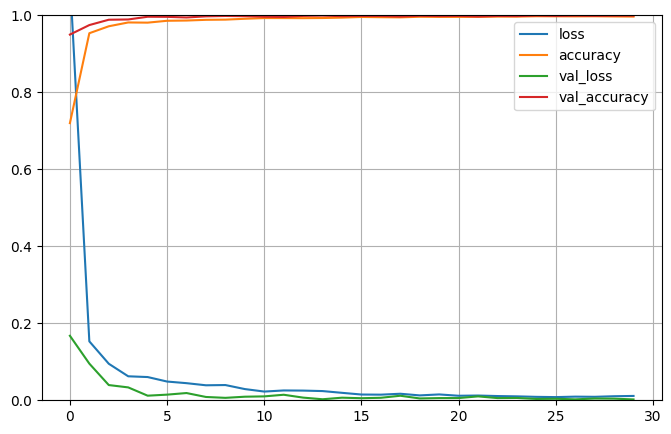

In [15]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.savefig('train_val_loss.png')
plt.show()

### Loading the test data and running the predictions

In [16]:
test = pd.read_csv('dataset/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data =[]

for img in imgs:
    try:
        image = Image.open('dataset/' + img)
        # rgb
        #image_fromarray = Image.fromarray(image, 'RGB')
        #resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        # grayscale
        image_fromarray = image.convert('L')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255

pred = model.predict(X_test).argmax(axis=-1)

#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(labels, pred)*100)

395/395 [==============================] - 10s 24ms/step
Test Data accuracy:  98.66983372921615


### Visualizing the confusion matrix

<Axes: >

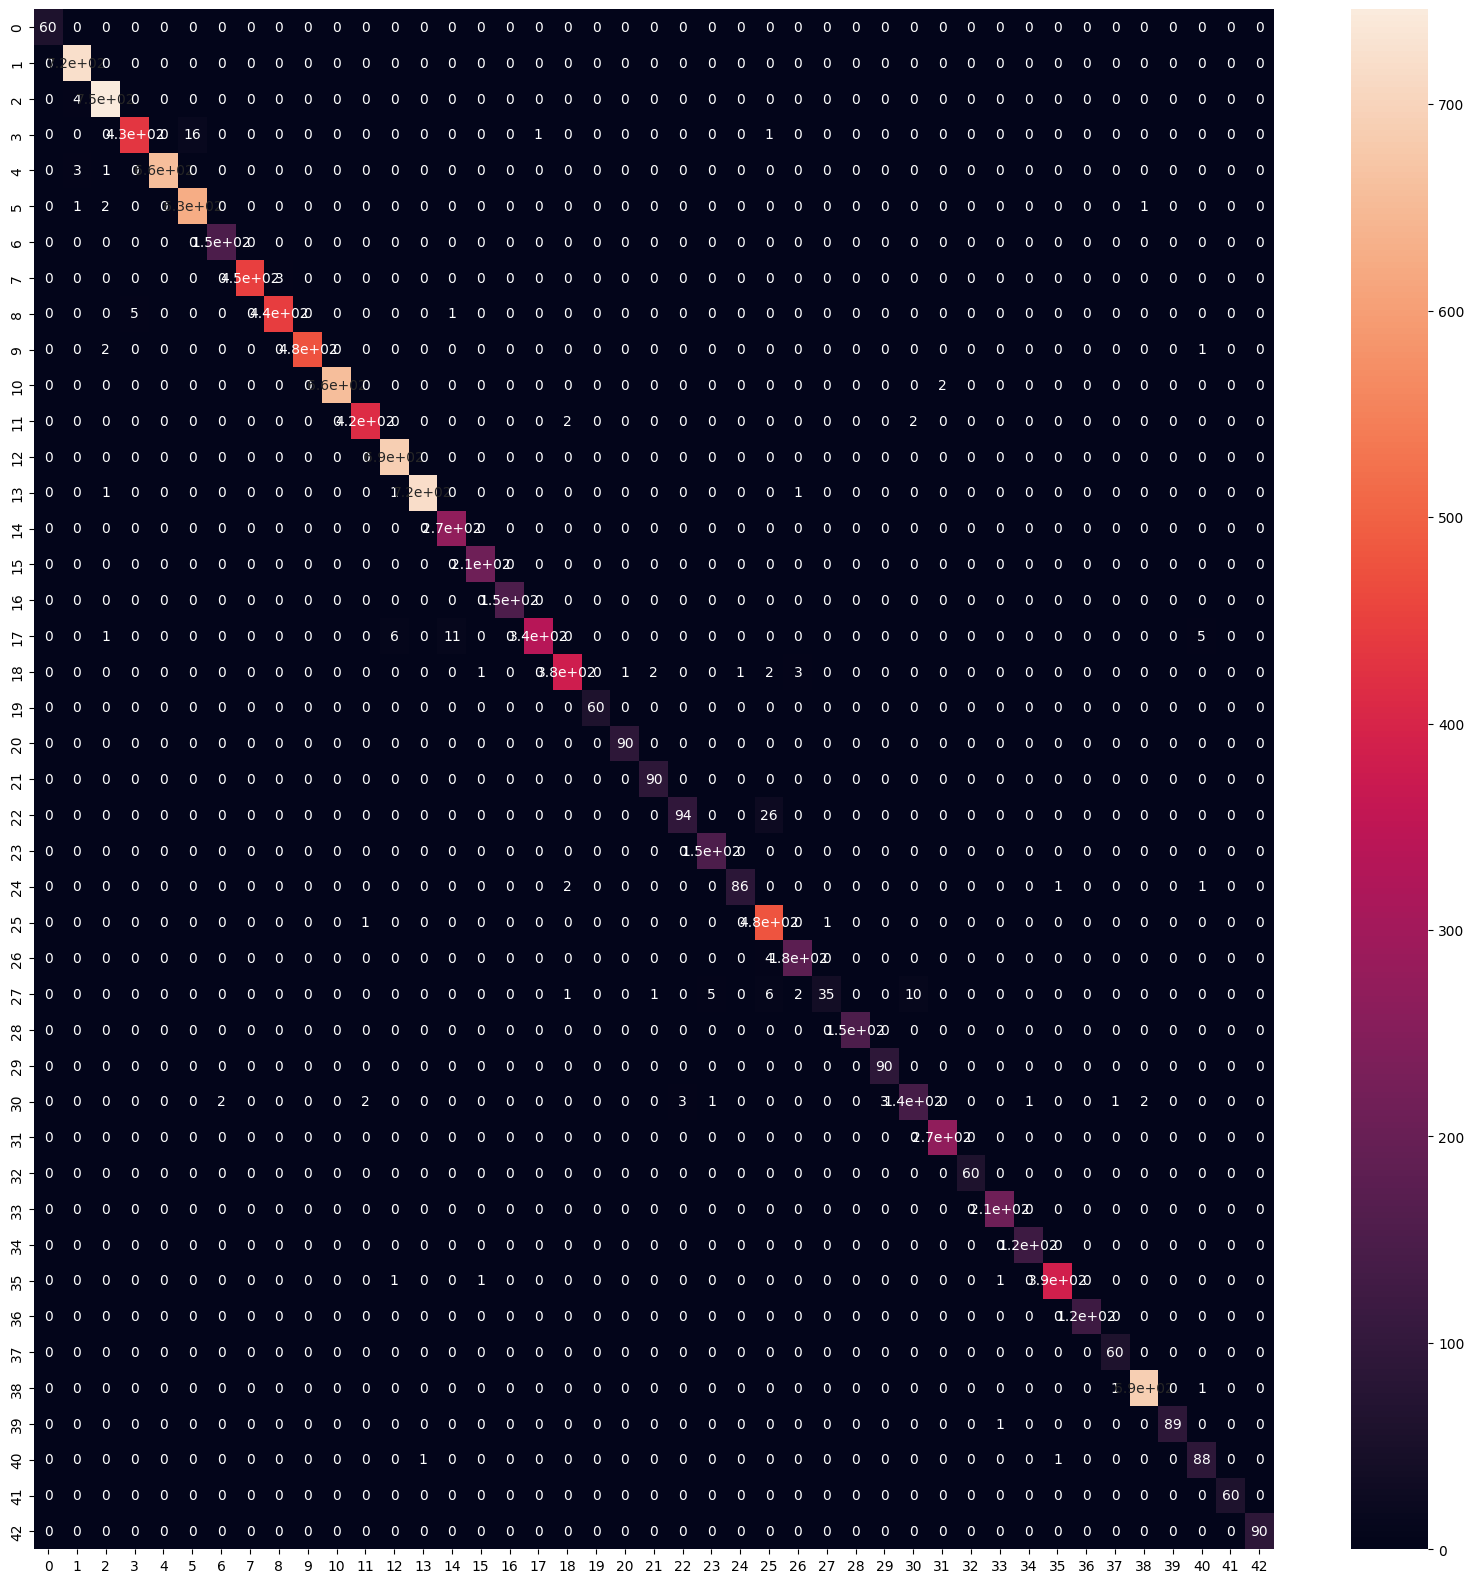

In [17]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(labels, pred)

df_cm = pd.DataFrame(cf, index = classes,  columns = classes)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)

### Accuracy of the model per class

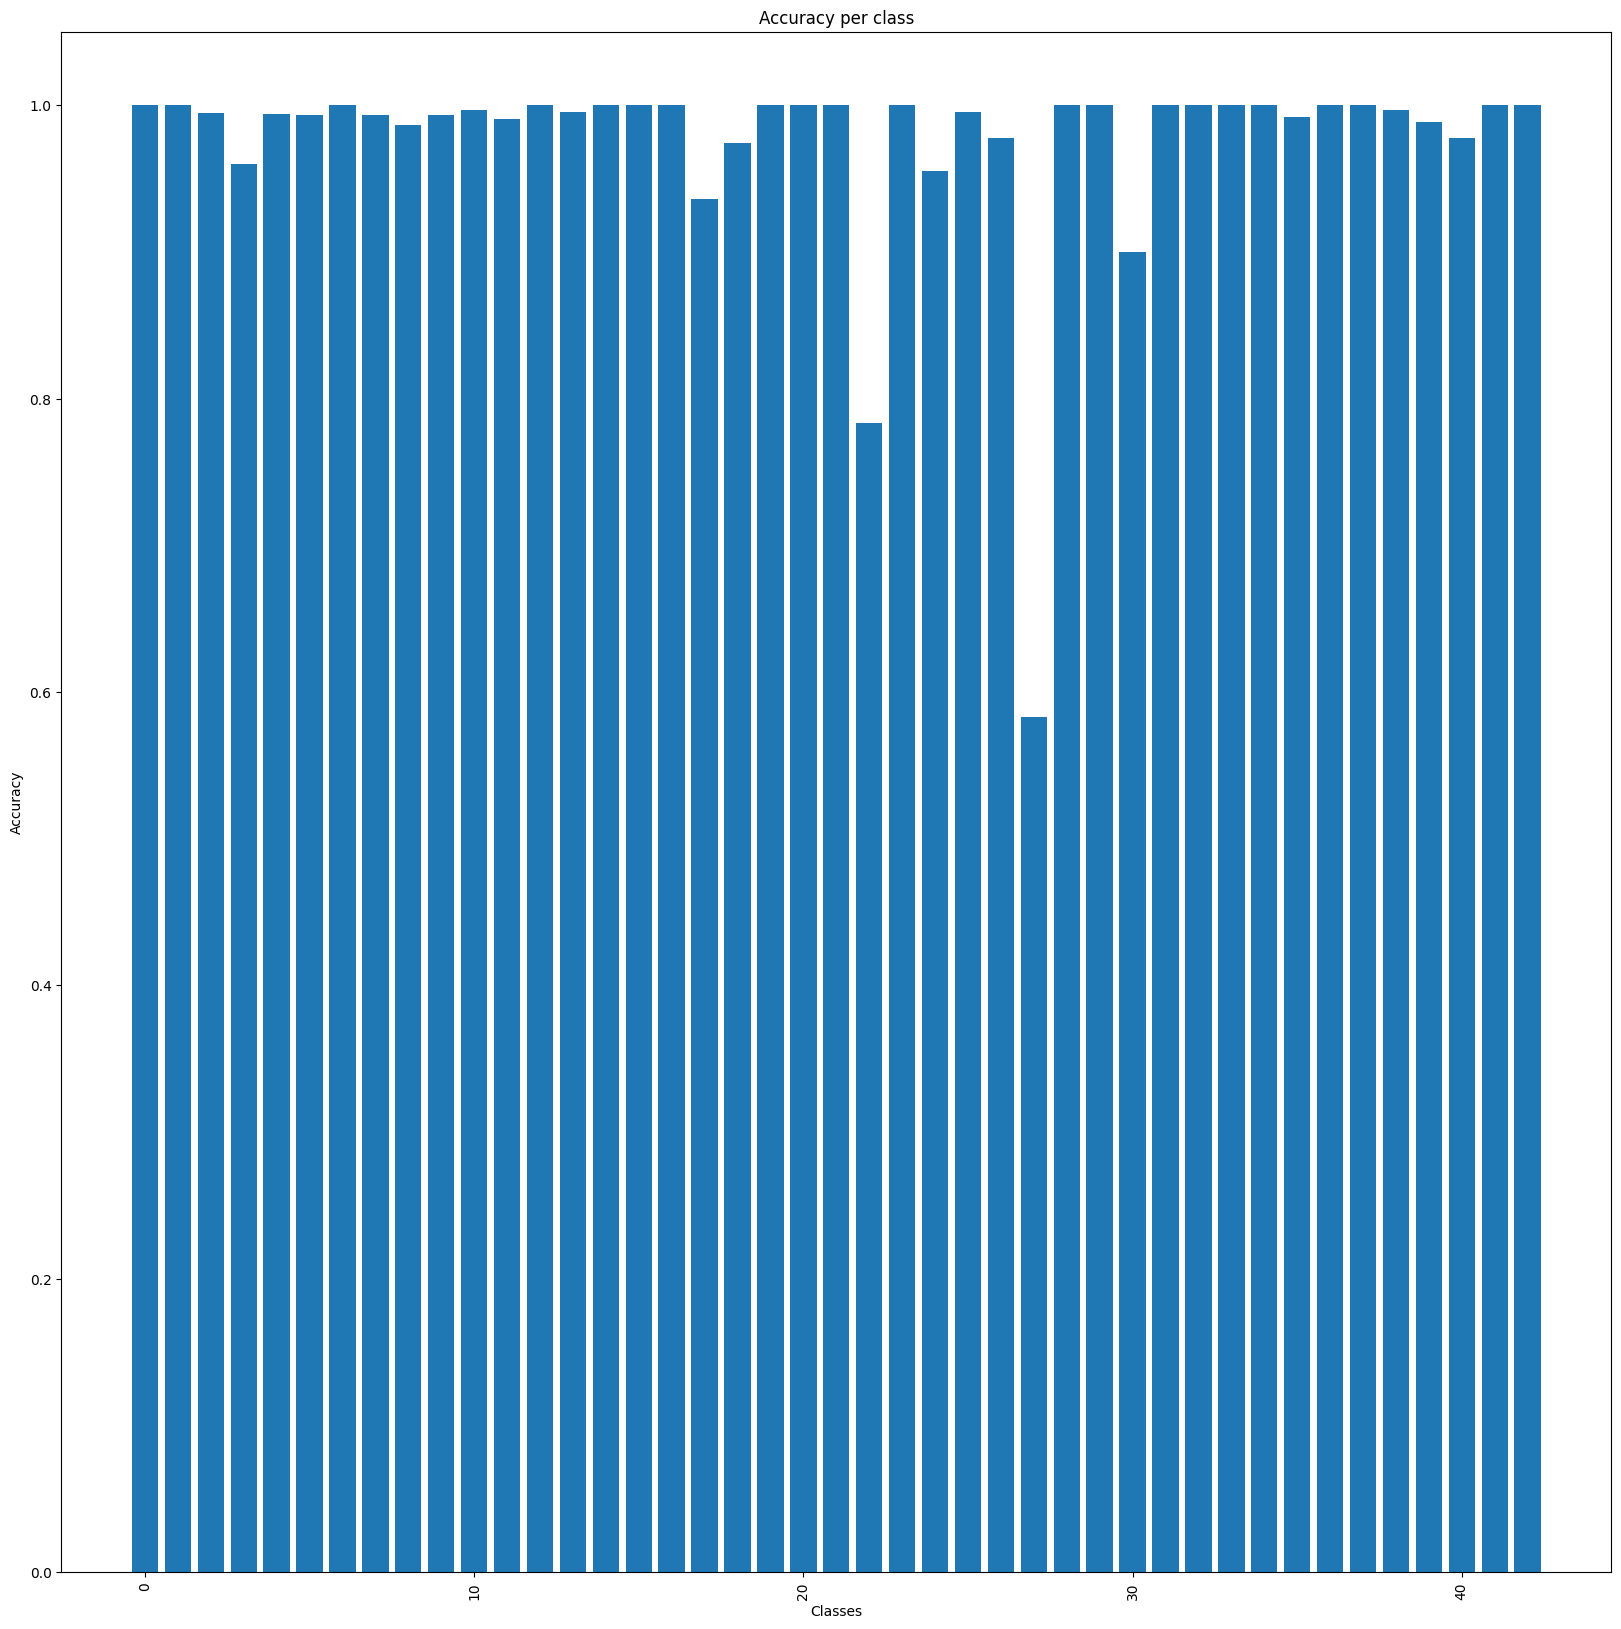

In [18]:
plt.figure(figsize=(20, 20))
plt.bar(classes, cf.diagonal()/cf.sum(axis=1))
plt.xticks(rotation=90)
plt.xlabel('Classes')
plt.ylabel('Accuracy')
plt.title('Accuracy per class')
plt.savefig('accuracy_per_class.png')
plt.show()

### Classification report

In [19]:
from sklearn.metrics import classification_report

print(classification_report(labels, pred))

model.save("traffic_classifier_kaggle_gray_scale_1channel.h5")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       0.99      1.00      0.99       720
           2       0.99      0.99      0.99       750
           3       0.99      0.96      0.97       450
           4       1.00      0.99      1.00       660
           5       0.98      0.99      0.98       630
           6       0.99      1.00      0.99       150
           7       1.00      0.99      1.00       450
           8       0.99      0.99      0.99       450
           9       1.00      0.99      1.00       480
          10       1.00      1.00      1.00       660
          11       0.99      0.99      0.99       420
          12       0.99      1.00      0.99       690
          13       1.00      1.00      1.00       720
          14       0.96      1.00      0.98       270
          15       0.99      1.00      1.00       210
          16       1.00      1.00      1.00       150
          17       1.00    

### Predictions on Test Data

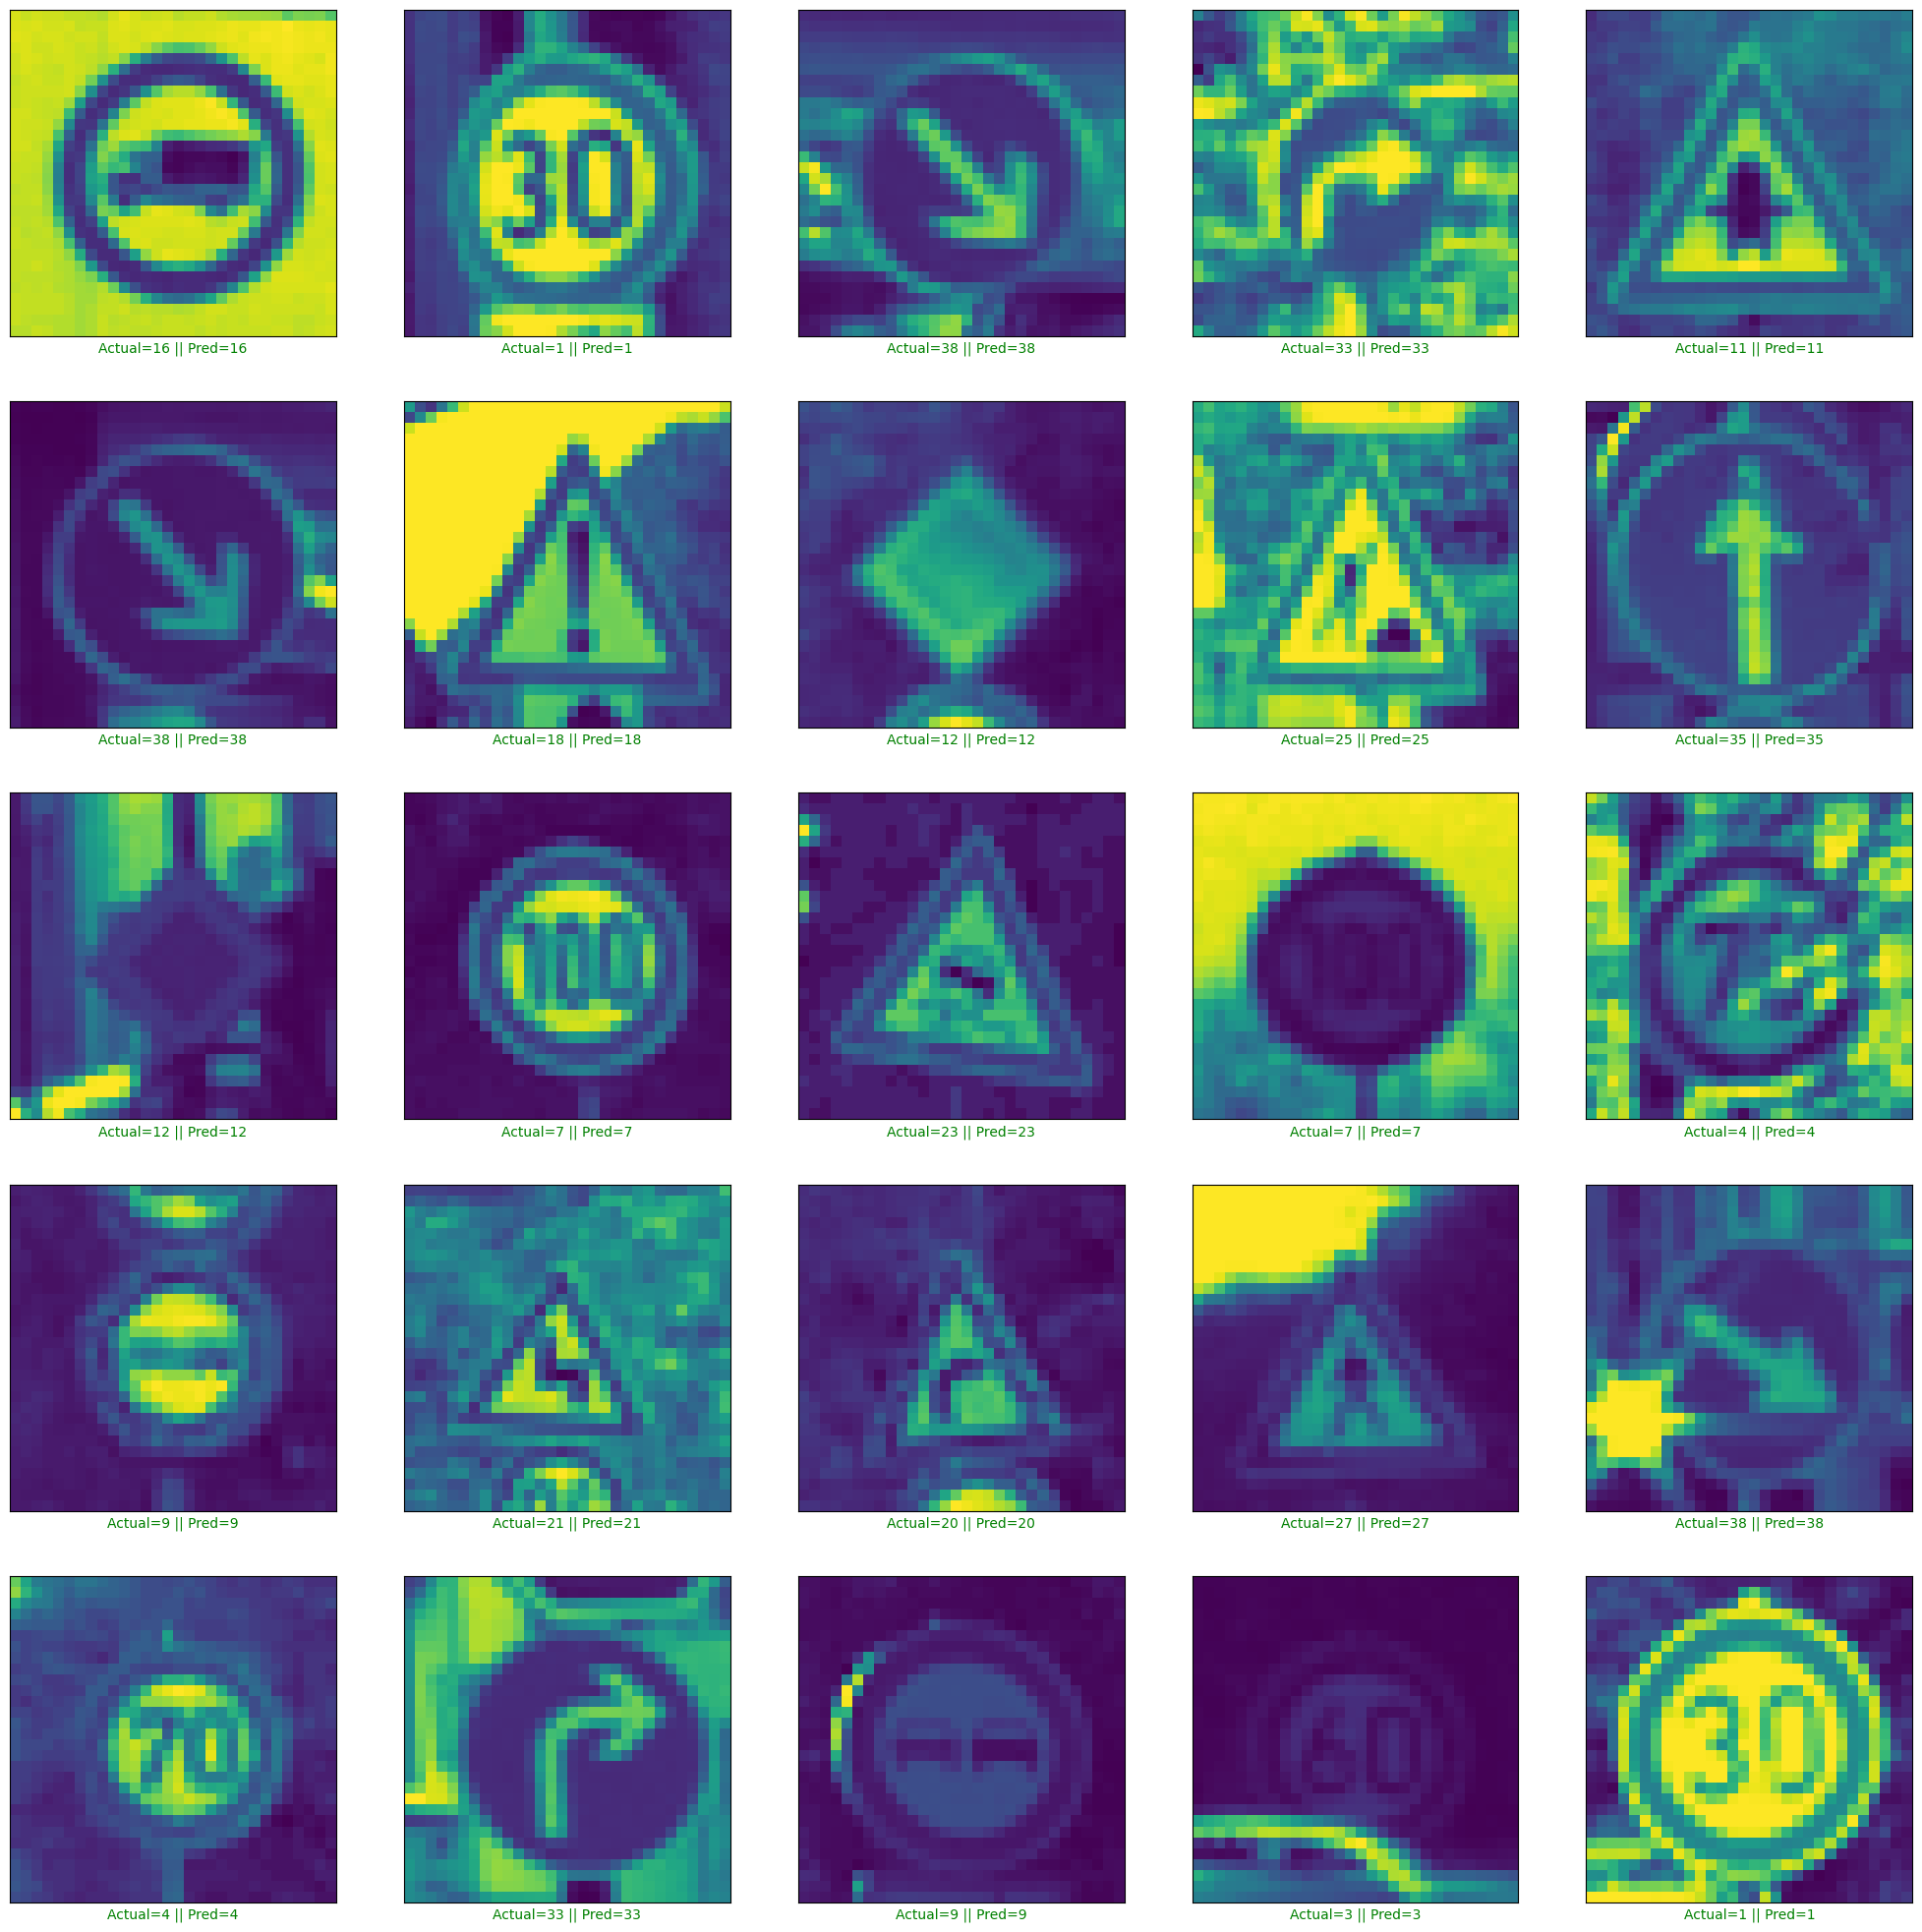

In [20]:
plt.figure(figsize = (25, 25))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual = labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()